# Scenario analysis: loss of cutup room

In [1]:
import openpyxl as oxl
from histopath_bim_des.config import Config
from histopath_bim_des.model import Model

path = 'config_base.xlsx'
wbook = oxl.load_workbook(path, data_only=True)
config = Config.from_workbook(wbook, sim_hours=10*168, num_reps=30, runner_speed=1.2)

In [2]:
config.resources.cut_up_assistant

ResourceInfo(name='Cut-up assistant', type='staff', schedule=ResourceSchedule(day_flags=[True, True, True, True, True, False, False], allocation=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [3]:
config.resources.bms

ResourceInfo(name='BMS', type='staff', schedule=ResourceSchedule(day_flags=[True, True, True, True, True, False, False], allocation=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [4]:
config.runner_times

RunnerTimesConfig(reception_cutup=8.452305794138642, cutup_processing=6.968697389230382, processing_microtomy=28.08925565098879, microtomy_staining=3.678511301977579, staining_labelling=3.678511301977579, labelling_scanning=86.89847882754336, scanning_qc=86.89847882754337, extra_loading=15.0, extra_unloading=15.0)

## Alt config

In [5]:
config2 = config.copy(deep = True)

In [6]:
# Copy from ifc_parsing_cutup.ipynb results
config2.runner_times.reception_cutup = 6.571348
config2.runner_times.cutup_processing = 8.678511
config2.runner_times

RunnerTimesConfig(reception_cutup=6.571348, cutup_processing=8.678511, processing_microtomy=28.08925565098879, microtomy_staining=3.678511301977579, staining_labelling=3.678511301977579, labelling_scanning=86.89847882754336, scanning_qc=86.89847882754337, extra_loading=15.0, extra_unloading=15.0)

In [7]:
# Reduce staffing by 1
config2.resources.cut_up_assistant.schedule.allocation = [max(0, x - 1) for x in config.resources.cut_up_assistant.schedule.allocation]
config2.resources.bms.schedule.allocation = [max(0, x - 1) for x in config.resources.bms.schedule.allocation]

In [8]:
config2.resources.cut_up_assistant.schedule

ResourceSchedule(day_flags=[True, True, True, True, True, False, False], allocation=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [9]:
config2.resources.bms.schedule

ResourceSchedule(day_flags=[True, True, True, True, True, False, False], allocation=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Simulation

In [10]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd

In [11]:
lab_tats = []
specimen_datas = []

for _ in range(config.num_reps):
    model_base = Model(config)
    model_base.run()
    lab_tat_new = [v['qc_end']-v['reception_start']
                   for v in model_base.specimen_data.values() if 'qc_end' in v]
    specimen_datas.append(model_base.specimen_data)
    lab_tats.append(lab_tat_new)

lab_tats2 = []
specimen_datas2 = []

for _ in range(config2.num_reps):
    model2 = Model(config2)
    model2.run()
    lab_tat_new = [v['qc_end']-v['reception_start']
                   for v in model2.specimen_data.values() if 'qc_end' in v]
    specimen_datas2.append(model2.specimen_data)
    lab_tats2.append(lab_tat_new)

In [12]:
lab_tat = np.concatenate(lab_tats)
lab_tat = lab_tat/24.

lab_tat2 = np.concatenate(lab_tats2)
lab_tat2 = lab_tat2/24.

mat1 = np.array([[np.mean(np.array(lab_tats[i])/24. < n) for n in [7,10,14,21]] for i in range(30)])
mat2 = np.array([[np.mean(np.array(lab_tats2[i])/24. < n) for n in [7,10,14,21]] for i in range(30)])

means1 = np.mean(mat1, axis=0)
means2 = np.mean(mat2, axis=0)

ci1 = [
    stats.t.interval(0.95, loc=np.mean(x:=mat1[:,col]), scale=stats.sem(x), df=len(x))
    for col in range(4)
]
yerr1 = np.array([v[1] for v in ci1])-means1

ci2 = [
    stats.t.interval(0.95, loc=np.mean(x:=mat2[:,col]), scale=stats.sem(x), df=len(x))
    for col in range(4)
]
yerr2 = np.array([v[1] for v in ci2])-means2

<Axes: xlabel='Elapsed time [days]', ylabel='Proportion of specimens completed'>

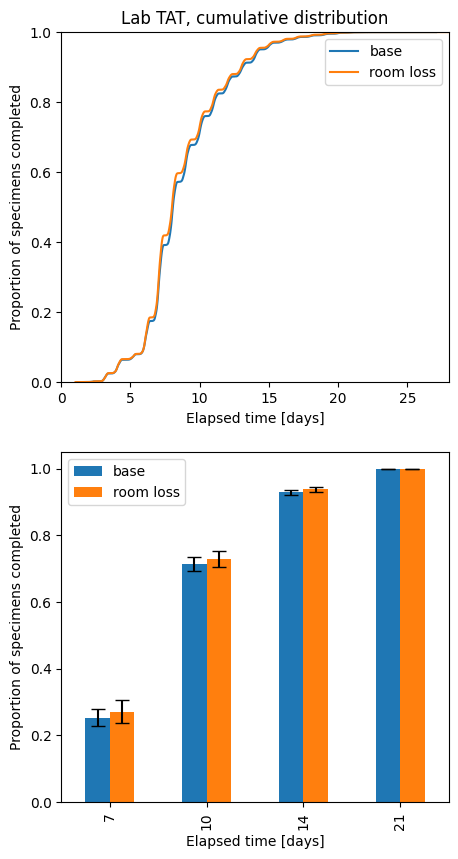

In [13]:
fig = plt.figure(figsize=(5,10))
ax1, ax2 = fig.subplots(2,1)

ax1.ecdf(lab_tat)
ax1.ecdf(lab_tat2)
ax1.legend(labels=['base', 'room loss'])
ax1.set_xlabel('Elapsed time [days]')
ax1.set_title('Lab TAT, cumulative distribution')
ax1.set_ylabel('Proportion of specimens completed')
ax1.set_xlim(0,28)

y_df = pd.DataFrame(
    np.array([means1, means2]).T,
    index=[7,10,14,21],
    columns=['base', 'room loss']
)
yerr_df = pd.DataFrame(
    np.array([yerr1, yerr2]).T,
    index=[7,10,14,21],
    columns=['base', 'room loss']
)
y_df.plot(ax=ax2, kind='bar',yerr=yerr_df, capsize=5,
          xlabel='Elapsed time [days]', ylabel='Proportion of specimens completed')